<a href="https://colab.research.google.com/github/alexfok/IntroDeepLearning2022/blob/main/IDL_Project_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Alexander Fok 308669944

Avi Dvir 204423735

Gal Cohen 204675805

# Project: Unsupervised Deep Embedding for Clustering Analysis - Part#2 - Experiments

**Project Supervisor**: May Malka.

In this project, we build a Unsupervised Deep Embedding for Clustering Analysis with AE, etc 


# **Section 1: Environment Initialization**

## Imports


In [1]:
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as nnF
from torchvision.utils import make_grid
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision.transforms.functional as F
from torchvision.utils import make_grid
import os
import zipfile


# Install dependencies
%pip install wget torch torchvision imageio
import wget

# Imports for MNIST loading
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import datasets, transforms

# Imports for STL10 loading
import sys
import os, sys, tarfile, errno
import random


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=5974c9c408097c8cf34dd3dc2294d52bcbc1339c77c5e54785dc51cf6ea641bc
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


## Control Variables and Initialization

In [2]:
# Notebook Control variables
DEBUG_STL10 = False
# Print DEBUG info
DEBUG = False
# Variable controlling debug prints while training\infering with NN
DEBUG_NN = False
# Create the data sets or load the preloaded np arrays
CREATE_DATA = True
# Path to save the created numpy arrays
array_save_path = '/content/gdrive/My Drive/IntroDeepLearning2022Data/project/data.npy'
# Path to load the created numpy arrays
array_load_path = '/content/gdrive/My Drive/IntroDeepLearning2022Data/project/data.npy.npz'
#best_model_path = '/content/gdrive/MyDrive/IntroDeepLearning2022Data/project/model_chkpt_epoch_20.pk'
#checkpoint_path = '/content/gdrive/MyDrive/IntroDeepLearning2022Data/project/model_chkpt_epoch_{}.pk'
#model_path = '/content/gdrive/My Drive/IntroDeepLearning2022Data/project_model2.pk'
model_path_stl10 = '/content/gdrive/My Drive/IntroDeepLearning2022Data/project/project_model2_stl10.pk'
model_path_mnist = '/content/gdrive/My Drive/IntroDeepLearning2022Data/project/project_model2_mnist.pk'
# Raw data set paths
path_train = "/content/gdrive/My Drive/IntroDeepLearning2022Data/project"
#path_train = "/content/gdrive/My Drive/IntroDeepLearning2022Data/data/train/*.*"
#path_test_m = "/content/gdrive/My Drive/IntroDeepLearning2022Data/data/test_m/*.*"
#path_test_w = "/content/gdrive/My Drive/IntroDeepLearning2022Data/data/test_w/*.*"
# Set random seeds

# use GPU for computation if possible: Go to RUNTIME -> CHANGE RUNTIME TYPE -> GPU
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('CPU\GPI device: {dev}')

torch.manual_seed(1)
torch.cuda.manual_seed(1)

CPU\GPI device: {dev}


Connect to your Google Drive, select the path in your drive for saving the checkpoints of your model, which we will train later.

## Helper Functions


In [3]:
# Function to count number of model parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

def plot_image(image):
    """
    :param image: the image to be plotted in a 3-D matrix format
    :return: None
    """
    plt.imshow(image)
    plt.show()

# Function to display images
def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 28, 28)
            plt.figure(figsize=(15, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N], cmap='Greys_r')
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(15, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N], cmap='Greys_r')
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

# Section 2: Data Load
## Data Statistics

In this assignement we are using the CelebFaces Attributes Dataset (CelebA).

The CelebA dataset, as its name suggests, is comprised of celebrity faces. The images cover large pose variations, background clutter, diverse people, supported by a large quantity of images and rich annotations. This data was originally collected by researchers at MMLAB, The Chinese University of Hong Kong.

**Overall**

- 202,599 number of face images of various celebrities
- 10,177 unique identities, but names of identities are not given
- 40 binary attribute annotations per image
- 5 landmark locations

In this torchvision version of the dataset, each image is in the shape of
$[218,178,3]$ and the values are in $[0,1]$.

MNIST Data
- number of images: 60000
- image shape: $(28, 28, 1)$.

STL10 Data
- stl10_binary.tar.gz size: 2.5 gb
- number of images: 5000
- image shape: $(96, 96, 3)$.
- 10 image classes: 
 `` airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck``

## Load MNIST dataset
We direclty load the images by batches. Note that we keep the division of the data into training and test sets to get some sense on how the variational autoencoder adapts during the trainig procedure. Nonetheless, there are no lables used here as this is unsupervised learning.

In [4]:
#mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
#mnist_data = list(mnist_data)[:4096]

#batch_size = 256
 
#train_loader = torch.utils.data.DataLoader(
#    MNIST('./data', train=True, download=True,
#                   transform=transforms.ToTensor()),
#    batch_size=batch_size, shuffle=True)
#test_loader = torch.utils.data.DataLoader(
#    MNIST('./data', train=False, transform=transforms.ToTensor()),
#    batch_size=batch_size, shuffle=True)

#mnist_data = train_loader.dataset.detach().numpy()
#mnist_data = train_loader.dataset
#mnist_data = next(iter(train_loader))[0].numpy()
def create_mnist_dataset():
    print(f'Creating MNIST dataset')
    norm_mean = 0.5 
    norm_std = 0.5 
#    image_h, image_w = (28, 28)
    image_size = (32, 32)

#    trfm = transforms.Compose([transforms.ToTensor(), transforms.Normalize((norm_mean,), (norm_std,))])
#    trfm = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor(), transforms.Grayscale(3)])
    trfm = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])
#    trfm = transforms.ToTensor()

    mnist_data = datasets.MNIST('data', train=True, download=True, transform=trfm)
    mnist_data_test = datasets.MNIST('data', train=False, download=True, transform=trfm)
    mnist_data_nparray = mnist_data.data.numpy()
    print(f'type(mnist_data_nparray): {type(mnist_data_nparray)}')
    print(f'len(mnist_data_nparray): {len(mnist_data_nparray)}')
    print(f'mnist_data.data.shape: {mnist_data.data.shape}')
    print(f'mnist_data_test.data.shape: {mnist_data_test.data.shape}')
    return mnist_data, mnist_data_test

## Load STL dataset
We direclty load the images by batches. Note that we keep the division of the data into training and test sets to get some sense on how the variational autoencoder adapts during the trainig procedure. Nonetheless, there are no lables used here as this is unsupervised learning.

In [5]:
import urllib.request as urllib
from imageio import imsave
print(sys.version_info) 

# image shape
HEIGHT = 96
WIDTH = 96
DEPTH = 3

# size of a single image in bytes
SIZE = HEIGHT * WIDTH * DEPTH

# path to the directory with the data
DATA_DIR = './data'
# url of the binary data
DATA_URL = 'http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz'
# path to the binary train file with image data
DATA_PATH = './data/stl10_binary/train_X.bin'
# path to the binary train file with labels
LABEL_PATH = './data/stl10_binary/train_y.bin'
# path to the binary test file with image data
TEST_DATA_PATH = './data/stl10_binary/test_X.bin'
# path to the binary test file with labels
TEST_LABEL_PATH = './data/stl10_binary/test_y.bin'
# path to the binary unlabeled file
UNLABELED_DATA_PATH = './data/stl10_binary/unlabeled_X.bin'
# path to the class names file
CLASS_NAMES_PATH = './data/stl10_binary/class_names.txt'

def read_class_names(path_to_class_names):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_class_names, 'r') as f:
        class_names = f.read()
        class_names_list = class_names.split("\n")
        # remove last empty '\n'
        class_names_list = class_names_list[:-1]
        return class_names_list

def read_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels

def read_all_images(path_to_data):
    """
    :param path_to_data: the file containing the binary images from the STL-10 dataset
    :return: an array containing all the images
    """

    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, 3, 96, 96))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
        return images


def read_single_image(image_file):
    """
    CAREFUL! - this method uses a file as input instead of the path - so the
    position of the reader will be remembered outside of context of this method.
    :param image_file: the open file containing the images
    :return: a single image
    """
    # read a single image, count determines the number of uint8's to read
    image = np.fromfile(image_file, dtype=np.uint8, count=SIZE)
    # force into image matrix
    image = np.reshape(image, (3, 96, 96))
    # transpose to standard format
    # You might want to comment this line or reverse the shuffle
    # if you will use a learning algorithm like CNN, since they like
    # their channels separated.
    image = np.transpose(image, (2, 1, 0))
    return image


def save_image(image, name):
    imsave("%s.png" % name, image, format="png")

def download_and_extract():
    """
    Download and extract the STL-10 dataset
    :return: None
    """
    dest_directory = DATA_DIR
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
    filename = DATA_URL.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\rDownloading %s %.2f%%' % (filename,
                float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
        filepath, _ = urllib.urlretrieve(DATA_URL, filepath, reporthook=_progress)
        print('Downloaded', filename)
        tarfile.open(filepath, 'r:gz').extractall(dest_directory)
    else:
        print(f'data set already downloaded: {filepath}')

def save_images(images, labels):
    print("Saving images to disk")
    i = 0
    for image in images:
        label = labels[i]
        directory = './img/' + str(label) + '/'
        try:
            os.makedirs(directory, exist_ok=True)
        except OSError as exc:
            if exc.errno == errno.EEXIST:
                pass
        filename = directory + str(i)
        print(filename)
        save_image(image, filename)
        i = i+1


if DEBUG_STL10:
    # download data if needed
    download_and_extract()

    # test to check if the image is read correctly
    with open(DATA_PATH) as f:
        image = read_single_image(f)
        plot_image(image)

    # test to check if the whole dataset is read correctly
    images = read_all_images(DATA_PATH)
    print(images.shape)

    labels = read_labels(LABEL_PATH)
    print(labels.shape)

    # save images to disk
    save_images(images, labels)

def create_stl10_dataset():
    print(f'Creating STL10 dataset')
    # download data if needed
#    dest_directory = DATA_DIR
#    if not os.path.exists(dest_directory):
    download_and_extract()
    # load train dataset to np array
    train_images = read_all_images(DATA_PATH)
    print(f'train_images.shape: {train_images.shape}')
    train_labels = read_labels(LABEL_PATH)
    print(f'train_labels.shape: {train_labels.shape}')

    # load test dataset to np array
    test_images = read_all_images(TEST_DATA_PATH)
    print(f'test_images.shape: {test_images.shape}')
    test_labels = read_labels(TEST_LABEL_PATH)
    print(f'test_labels.shape: {test_labels.shape}')

    class_names = read_class_names(CLASS_NAMES_PATH)
    print(f'len(class_names): {len(class_names)}')
    

    # load unlabeled dataset to np array
#    unlabeled_images = read_all_images(UNLABELED_DATA_PATH)
#    print(f'unlabeled_images.shape: {unlabeled_images.shape}')
#    return train_images, train_labels, test_images, test_labels, unlabeled_images
    unlabeled_images = np.zeros(10)
    return train_images, train_labels, test_images, test_labels, unlabeled_images, class_names


sys.version_info(major=3, minor=8, micro=10, releaselevel='final', serial=0)


## Create or Load Datasets

In [6]:
# Save numpy arrays
def save_numpy_arrays(mnist_data_nparray, stl10_data_nparray):
  np.savez(array_save_path, mnist_data_nparray = mnist_data_nparray, stl10_data_nparray = stl10_data_nparray)

# Load numpy arrays
def load_numpy_arrays(array_load_path):
  stl10_data_nparray = None
  mnist_data_nparray = None
  data = np.load(array_load_path, allow_pickle = True)
  stl10_data_nparray = data['stl10_data_nparray']
  mnist_data_nparray = data['mnist_data_nparray']
  if DEBUG:
    print(f'loaded data.files {data.files}')
    print(f'stl10_data_nparray.shape {stl10_data_nparray.shape}')
    print(f'mnist_data_nparray.shape {mnist_data_nparray.shape}')
  return mnist_data_nparray, stl10_data_nparray


# These data sets will be initialized at the end of this cell
#stl10_data_nparray = None
#stl10_labels_nparray = None
#mnist_data_nparray = None
mnist_test_split, mnist_train_split = None, None
stl10_test_split, stl10_train_split = None, None
stl10_labels_test_split, stl10_labels_train_split = None, None
stl10_train_split_unlabeled = None
stl10_class_names = None
#CREATE_DATA = False
#DEBUG = True
if CREATE_DATA:
  # Create and save data sets
#  print('Create numpy arrays from raw data sets and save to GDrive')
  print('Create numpy arrays from raw data sets')
#  stl10_data_nparray, stl10_labels_nparray = create_stl10_dataset()
  stl10_train_split, stl10_labels_train_split, stl10_test_split, stl10_labels_test_split, stl10_train_split_unlabeled, stl10_class_names = create_stl10_dataset()
  mnist_train_split, mnist_test_split = create_mnist_dataset()
  # Do not save data nparrays in GDrive
#  save_numpy_arrays(mnist_data_nparray, stl10_data_nparray)
else:
  print('Load the numpy arrays from GDrive isnot supported')
  # Load the data files and initiate global variables:
  # train_data, test_m_data, test_w_data, valid_set, train_set
  # Verify that data file exists
  # !ls -la $array_load_path
#  mnist_data_nparray, stl10_data_nparray = load_numpy_arrays(array_load_path)

#img1 = mnist_data_nparray[0]
#print(f'img1.shape: {img1.shape}')
#print(f'img1: {img1}')
#plot_image(img1)

#img2 = stl10_data_nparray[0]
#print(f'img2.shape: {img2.shape}')
#print(f'img2: {img2}')
#plot_image(img2)
#label1 = stl10_labels_nparray[1024]
#print(f'label1.shape: {label1.shape} {label1}')
#stl10_data_nparray = None
#stl10_labels_nparray = None
#mnist_data_nparray = None

# Shift STL10 labels from range 1..10 to range 0..9
stl10_labels_train_split = stl10_labels_train_split -1
stl10_labels_test_split = stl10_labels_test_split -1

# Normalize datasets
# Process the loaded data
# Divide data by 255
#mnist_data_nparray = mnist_data_nparray/255.0
stl10_train_split = stl10_train_split/255.0
stl10_test_split = stl10_test_split/255.0
stl10_train_split_unlabeled = stl10_train_split_unlabeled/255.0

#mnist_data_nparray = mnist_data_nparray.astype(np.float32)
stl10_train_split = stl10_train_split.astype(np.float32)
stl10_test_split = stl10_test_split.astype(np.float32)
stl10_train_split_unlabeled = stl10_train_split_unlabeled.astype(np.float32)
# Subtract 0.5
#mnist_data_nparray -= 0.5
#stl10_data_nparray -= 0.5

# debug normalized images
#img1 = mnist_data_nparray[0]
#print(f'img1.shape: {img1.shape}')
#print(f'img1: {img1}')
#plot_image(img1)
#img2 = stl10_data_nparray[0]
#print(f'img2.shape: {img2.shape}')
#print(f'img2: {img2}')
#plot_image(img2)

# Split the train data to train (80%) and test (20%) data sets
def split_data(data_nparray):
  split_idx = int(data_nparray.shape[0]/5)
  print(f'data_nparray.shape: {data_nparray.shape}, split_idx: {split_idx}')
  test_split, train_split = data_nparray[:split_idx], data_nparray[split_idx:]
  print(f'test_split.shape: {test_split.shape}, train_split.shape: {train_split.shape}')
  return test_split, train_split

#mnist_test_split, mnist_train_split = split_data(mnist_data_nparray)
#stl10_test_split, stl10_train_split = split_data(stl10_data_nparray)
#stl10_labels_test_split, stl10_labels_train_split = split_data(stl10_labels_nparray)

Create numpy arrays from raw data sets
Creating STL10 dataset
train_images.shape: (5000, 96, 96, 3)
train_labels.shape: (5000,)
test_images.shape: (8000, 96, 96, 3)
test_labels.shape: (8000,)
len(class_names): 10
Creating MNIST dataset


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

type(mnist_data_nparray): <class 'numpy.ndarray'>
len(mnist_data_nparray): 60000
mnist_data.data.shape: torch.Size([60000, 28, 28])
mnist_data_test.data.shape: torch.Size([10000, 28, 28])


# Section 3 Images Classifier

## VAE Foundations


## ELBO
 A we see above, the $ELBO = -D_{KL}\big(q(z|x_i)||P(z)\big) + E_{~q(z|x_i)}\big[\log\big(P(x_i|z)\big)\big]$ is comprised of 2 terms. Explain the meaning of each one of them in terms of a loss function.



**Minimizing** the loss function, over a batch in the dataset now can be written as:

$\mathcal{L(\theta,\phi)} = -\sum_j^J\bigg(\frac{1}{2}\big[1+\log(\sigma_{q_j}^2)-\sigma_{q_j}^2-\mu_{q_j}^2\big]\bigg) - \frac{1}{M}\sum_i^M\bigg(E_{~q_{\theta}(z|x_i)}\big[\log\big(P_{\phi}(x_i|z)\big)\big]\bigg)$

where $J$ is the dimension of the latent vector $z$ and $M$ is the number of samples stochastically drawn from the dataset.

## VAE Implementation

As seen in class, a suitable way to extract features from dataset of images is by convolutional neural network (CNN). Hence, here you will build a convolutional VAE.
\
The basic idea is to start from full resolution images, and by convolutional kernels extract the important features of the dataset. Remember that the output of the VAE should be in the same dimensions $(H_1,W_1,C_1)$ as the input images. 

**The encoder** should be comprised of convolutional layers (nn.Conv2d). Recall that the dimension of the input images is changing according to:

$Z = \bigg(H_2(=\frac{H_1-F+2P}{S}+1),W_2(=\frac{W_1-F+2P}{S}+1),C_2\bigg)$

where $S$ is the stride, $F$ is the kernel size, $P$ is the zero padding and $C_2$ is the selected output channels. $Z$ is the output image.

**The decoder** should reconstruct the images from the latent space. In order to enlarge dimensions of images, your network should be comprised of transposed convolutional layers (nn.ConvTranspose2d). See the following images of the operation of transpose convolution to better understand the way it works.




The architecture of your VAE network should be in the following form:


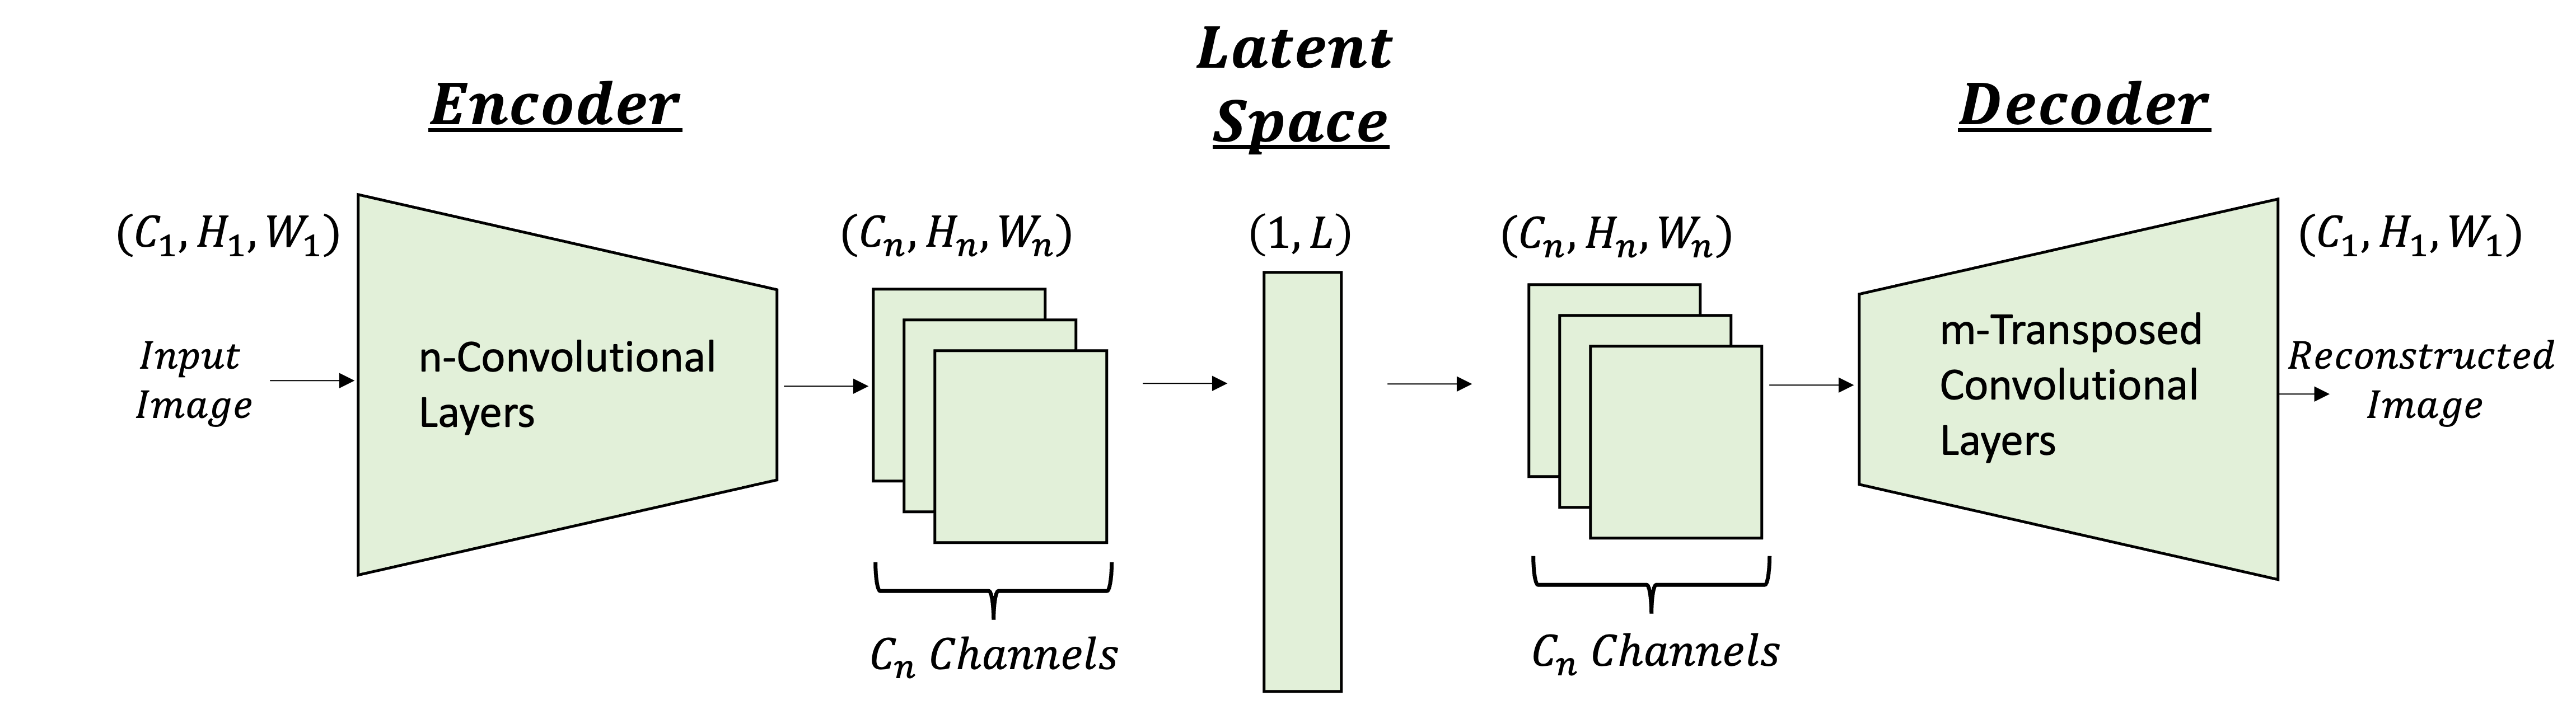

### Encoder

Here, you will implement the architecture of the encoder. 

The encoder should consist of 4 Blocks as follows:

BLOCK 1: 
- Convolutional layer (nn.Conv2D(in_channels, num_hidden, kernel_size=(3,3), stride=(2,2)))
- Batch Normalization(num_hidden)
- Activation Function: nn.ReLU()

BLOCK 2: 
- Convolutional layer (nn.Conv2D(num_hidden, num_hidden * 2, kernel_size=(3,3), stride=(2,2))
- Batch Normalization(num_hidden * 2)
- Activation Function: nn.ReLU()

BLOCK 3: 
- Convolutional layer (nn.Conv2D(num_hidden * 2, num_hidden * 4, kernel_size=(3,3), stride=(2,2))
- Batch Normalization(num_hidden * 4)
- Activation Function: nn.ReLU()

BLOCK 4: 
- Convolutional layer (nn.Conv2D(num_hidden * 4, num_hidden * 8, kernel_size=(3,3), stride=(2,2))
- Batch Normalization(num_hidden * 8)
- Activation Function: nn.ReLU()

In addidion to the 4 Blocks, you should add the following linear layers:

Linear $\mu$: 
- nn.Linear( ___ ,latent). 

Linear $\log(\sigma)$: 
- nn.Linear( ___ ,latent).

**NOTES:** 

- The input of the linear layer should be according to the size of the images you picked in the transformation part. (If you did resize the images)

- Consider using Padding in the convolutional layers to correct mismatches in sizes.

- In the forward function, you will have to reshape the output from the 4'th block to $(Batch\cdot H_4\cdot W_4\cdot C_4 , latent)$, where $(Batch$ is the batch size, $H_4$ is the height of the output image from the 4'th block, $W_4$ is the width of the output image from the 4'th block and $C_4$ is num_hidden*8 (number of channels of the output image from the 4'th block).

**You can change any parameter of the network to suit your code - this is only a recommendation.**

In [7]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, latent, input_shape=(1, 28, 28)):
        super(Encoder, self).__init__()
        # YOUR CODE GOES HERE:
        print(f'Encoder: in_channels: {in_channels}, num_hiddens: {num_hiddens}, latent: {latent}, input_shape: {input_shape}')
        self.kernel_size = 3
        self.stride = 2
        self.in_channels = in_channels
        padding_num = int((self.kernel_size-1)/2)
        self.padding = (padding_num, padding_num)
        self.C, self.H, self.W = input_shape

        self.num_hiddens = num_hiddens
        self.latent = latent
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, num_hiddens, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=self.padding),
            # Batch Normalization(num_hidden)
            nn.BatchNorm2d(num_hiddens),
            nn.ReLU()
            )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(num_hiddens, num_hiddens * 2, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=self.padding),
            # Batch Normalization(num_hidden*2)
            nn.BatchNorm2d(num_hiddens*2),
            nn.ReLU()
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(num_hiddens * 2, num_hiddens * 4, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=self.padding),
            # Batch Normalization(num_hidden*4)
            nn.BatchNorm2d(num_hiddens*4),
            nn.ReLU()
        )
        
        self.block4 = nn.Sequential(
            nn.Conv2d(num_hiddens * 4, num_hiddens * 8, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=self.padding),
            # Batch Normalization(num_hidden*8)
            nn.BatchNorm2d(num_hiddens*8),
            nn.ReLU()

        )
        self.flatten = torch.nn.Flatten()
        self.relu = torch.nn.ReLU()
      # after 4 Conv2D with stride=(2,2), the image shape is (h/(2**4),w/(2**4)), with 8*num_hiddens channels
      # thus, Linear input shape: (8*num_hiddens)*((self.H*self.W)/(2**8))
        fc1_inp = int((8*self.num_hiddens)*((self.H*self.W)/(2**8)))

        # n_linear_size = int(((image_h-3)/2 + 1)**2)
        print(f'fc1_inp: {fc1_inp}')
        self.fc_mu = nn.Linear(fc1_inp, latent)     # Insert the input size
        self.fc_logvar = nn.Linear(fc1_inp, latent) # Insert the input size

    def forward(self, inputs):
        # YOUR CODE GOES HERE:
        if DEBUG_NN:
          print(f'encoder forward: inputs.shape: {inputs.shape}')
        x = self.block1(inputs)
        if DEBUG_NN:
          print(f'block1(x): x.shape: {x.shape}')

        x = self.block2(x)
        if DEBUG_NN:
          print(f'block2(x): x.shape: {x.shape}')

        x = self.block3(x)
        if DEBUG_NN:
          print(f'block3(x): x.shape: {x.shape}')

        x = self.block4(x)
        if DEBUG_NN:
          print(f'block4(x): x.shape: {x.shape}')

        #x.view(-1, image_h*image_w*3), self.num_hiddens, self.latent
        x = self.flatten(x)
        if DEBUG_NN:
          print(f'flatten(x): x.shape: {x.shape}')
#        print(f'fc1(x): z.shape: {z.shape}')
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        if DEBUG_NN:
          print(f'encoder forward: fc_logvar(x): mu.shape, logvar.shape: {mu.shape}, {logvar.shape}')
        return mu, logvar

**Notice: We output $\log\sigma$ and not $\sigma^2$, this is a convention when training VAEs but it is completely equivalent.**

### Decoder

Here, you will implement the architecture of the decoder. 

First, Apply a linear layer to the input of the decoder as follows:

- nn.Linear(latent, ___ ).

The output of the linear layer should match to $Batch\cdot H_4\cdot W_4\cdot C_4$, which were the same parameters from the encoder 4'th block's output.

Then, the decoder should consist of 4 Blocks as follows:

BLOCK 1: 
- Transposed Convolutional layer (nn.ConvTranspose2d(in_channels, num_hidden // 2, kernel_size=(4,4), stride=(2,2)))
- Batch Normalization(num_hidden // 2)
- Activation Function: nn.ReLU() or nn.LeakyReLU()

BLOCK 2: 
- Transposed Convolutional layer (nn.ConvTranspose2d(num_hidden // 2, num_hidden // 4, kernel_size=(4,4), stride=(2,2)))
- Batch Normalization(num_hidden // 4)
- Activation Function: nn.ReLU() or nn.LeakyReLU()

BLOCK 3: 
- Transposed Convolutional layer (nn.ConvTranspose2d(num_hidden // 4, num_hidden // 8, kernel_size=(4,4), stride=(2,2)))
- Batch Normalization(num_hidden // 8)
- Activation Function: nn.ReLU() or nn.LeakyReLU()

BLOCK 4: 
- Transposed Convolutional layer (nn.ConvTranspose2d(num_hidden // 8, num_hidden // 8, kernel_size=(4,4), stride=(2,2)))
- Batch Normalization(num_hidden // 8)
- Activation Function: nn.ReLU() or nn.LeakyReLU()


Afterwards, we should generate an image in the same size as our input images. Thus add 1 more block consisting of:

BLOCK 5:
 - nn.Conv2d(num_hiddens//8, out_channels=3,kernel_size=(3,3), stride=(1,1), padding=(1,1)),
 - Activation function.

**NOTES:** 

- The output of the linear layer should be according to the size of the images you picked in the transformation part. (If you did resize the images)

- Consider using Padding in the  transposed convolutional layers to correct mismatches in sizes.

- In the forward function, you will have to reshape the output of the linear layer to ($Batch, H_4, W_4, C_4$)

- The output of the decoder should be of values in $[0,1]$.



**You can change any parameter of the network to suit your code, this is only a recommendation.**

In [8]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens,latent, input_shape=(1, 28, 28)):
        super(Decoder, self).__init__()
        # YOUR CODE GOES HERE:
        print(f'Decoder: in_channels: {in_channels}, num_hiddens: {num_hiddens}, latent: {latent}, input_shape: {input_shape}')
        self.kernel_size = 4
        self.stride = 2
        self.in_channels = in_channels
        padding_num = int((self.kernel_size-1)/2)
        self.padding = (padding_num, padding_num)
        self.C, self.H, self.W = input_shape

        self.latent = latent
        self.num_hiddens = num_hiddens

        # after 4 Conv2D with stride=(2,2), the image shape is (h/(2**4),w/(2**4)), with 8*n channels
        # thus, Linear input shape: (8*n)*((self.H*self.W)/(2**8))
        fc1_inp = int((8*self.num_hiddens)*((self.H*self.W)/(2**8)))
        img_s = (self.H*self.W)//2**8

        self.fc_dec = nn.Linear(latent, fc1_inp) # Insert the output size

        self.block1 = nn.Sequential(
            nn.ConvTranspose2d(fc1_inp // img_s, num_hiddens // 2, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=1),
            # Batch Normalization(num_hidden)
            nn.BatchNorm2d(num_hiddens // 2),
            nn.LeakyReLU(0.1)
            )
        
        self.block2 = nn.Sequential(
            nn.ConvTranspose2d(num_hiddens // 2, num_hiddens // 4, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=1),
            # Batch Normalization(num_hidden)
            nn.BatchNorm2d(num_hiddens // 4),
            nn.LeakyReLU(0.1)
            )

        self.block3 = nn.Sequential(
            nn.ConvTranspose2d(num_hiddens // 4, num_hiddens // 8, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=1),
            # Batch Normalization(num_hidden)
            nn.BatchNorm2d(num_hiddens // 8),
            nn.LeakyReLU(0.1)
            )
        
        self.block4 = nn.Sequential(
            nn.ConvTranspose2d(num_hiddens // 8, num_hiddens // 8, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=1),
            # Batch Normalization(num_hidden)
            nn.BatchNorm2d(num_hiddens // 8),
            nn.LeakyReLU(0.1)
            )

        self.block5 = nn.Sequential( # Add convolution layer and activation layer
            nn.Conv2d(num_hiddens // 8, 3, kernel_size=(3,3), stride=(1,1), padding=1),
            # Batch Normalization(num_hidden)
            nn.LeakyReLU(0.1)
            )

        self.flatten = torch.nn.Flatten()
        self.le_relu = torch.nn.LeakyReLU(0.1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        # YOUR CODE GOES HERE:
        if DEBUG_NN:
          print(f'decoder forward: inputs.shape: {inputs.shape}')

        x = self.fc_dec(inputs)
        if DEBUG_NN:
          print(f'fc_dec(x): x.shape: {x.shape}')

        H = int(self.H/(2**4))
        W = int(self.W/(2**4))
        C = int(8*self.num_hiddens)
        x = x.reshape(-1,C,H,W)
#        x = x.view(N,C,H,W)
        if DEBUG_NN:
          print(f'reshaped x: x.shape: {x.shape}')


        x = self.block1(x)
        if DEBUG_NN:
          print(f'block1(x): x.shape: {x.shape}')

        x = self.block2(x)
        if DEBUG_NN:
          print(f'block2(x): x.shape: {x.shape}')

        x = self.block3(x)
        if DEBUG_NN:
          print(f'block3(x): x.shape: {x.shape}')

        x = self.block4(x)
        if DEBUG_NN:
          print(f'block4(x): x.shape: {x.shape}')

        x = self.block5(x)
        if DEBUG_NN:
          print(f'block5(x): x.shape: {x.shape}')

        x_rec = self.sigmoid(x)
        if DEBUG_NN:
          print(f'decoder forward: sigmoid(x): x_rec.shape: {x_rec.shape}')

        return x_rec

### VAE Model

Once you have the architecture of the encoder and the decoder, we want to put them together and train the network end-to-end.

Remember that in VAEs, you need to sample from a gaussian distribution at the input of the decoder. In order to backpropagate through the network, we use the reparametrization trick. The reparametrization trick is saying that sampling from $𝑧∼N(\mu,\sigma)$ is equivalent to sampling $\varepsilon∼N(0,1)$ and setting $𝑧=\mu+\sigma⊙\varepsilon$. Where, epsilon is an input to the network while keeping your sampling operation differentiable.
The reparametrization function is given to you in the VAE class.

Here, you should write the *forward()* function and to combine all the model's settings to a final network.

In [9]:
class VAE(nn.Module):
    def __init__(self, enc_in_chnl,enc_num_hidden,dec_in_chnl,dec_num_hidden,latent, input_shape=(1, 28, 28)):
        super(VAE, self).__init__()
        self.num_hidden = dec_num_hidden
        self.latent = latent
        self.encode = Encoder(in_channels = enc_in_chnl, num_hiddens = enc_num_hidden,latent = latent, input_shape = input_shape)
        self.decode = Decoder(in_channels = dec_in_chnl, num_hiddens = dec_num_hidden,latent = latent, input_shape = input_shape)

    # Reparametrization Trick
    def reparametrize(self, mu, logvar):
      std = torch.exp(0.5 * logvar)
      eps = torch.randn_like(std)     
      return eps.mul(std).add_(mu)

    # Initialize Weights
    def weight_init(self, mean, std):
        for m in self._modules:
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                m.weight.data.normal_(mean, std)
                m.bias.data.zero_()

    def forward(self, x):
        # YOUR CODE GOES HERE:
        if DEBUG_NN:
          print(f'VAE forward: inputs.shape: {x.shape}')

        mu, logvar = self.encode(x)
        if DEBUG_NN:
          print(f'VAE forward: mu.shape, logvar.shape: {mu.shape}, {logvar.shape}')
        z = self.reparametrize(mu, logvar)
        if DEBUG_NN:
          print(f'z.shape: {z.shape}')

        x_rec = self.decode(z)
        if DEBUG_NN:
          print(f'VAE forward: x_rec.shape: {x_rec.shape}')

        return x_rec , mu, logvar


### Loss Function

As we saw earlier, the loss function is based on the ELBO; Over a batch in the dataset, it can be written as:

$\mathcal{L(\theta,\phi)} = -\sum_j^J\bigg(\frac{1}{2}\big[1+\log(\sigma_{q_j}^2)-\sigma_{q_j}^2-\mu_{q_j}^2\big]\bigg) - \frac{1}{M}\sum_i^M\bigg(E_{~q_{\theta}(z|x_i)}\big[\log\big(P_{\phi}(x_i|z)\big)\big]\bigg)$

where $J$ is the dimension of the latent vector $z$ and $M$ is the number of samples stochastically drawn from the dataset.

**$\beta$-Variational Autoencoder ($\beta$-VAE)**

As seen in class, the fact that the ELBO is comprised of the sum of two loss terms implies that these can be balanced using an additional hyperparameter $\beta$, i.e.,

$\beta\cdot D_{KL}\big(q(z|x_i)||P(z)\big) - E_{~q(z|x_i)}\big[\log\big(P(x_i|z)\big)\big]$

It is highly recommended to use the $\beta$-loss for increasing performance. 
 


Explain what could be the purpose of the hyperparameter $\beta$ in the loss function? If $\beta = 1$ is same as VAE, What is the effect of $\beta \neq 1$?

The DKL term is regularization term, and the E() is reconstruction term. The hyperparameter $\beta$ in the loss function controls the balance between these two terms. With $\beta < 1$,
the reconstruction term has stronger effect on the ELBO result. It will cause the trained model to emphisize the reconstruction of the inputs  over the latent regularization. Very small $\beta$ value can cause the model overfitting.
With high $\beta$ the trained model can prefer the regularization term that might cause to poor reconstruction results and lead to underfitting.


Here you should write specifically the code for the loss function.


In [10]:
beta = 0.1
beta = 0.5
def vae_loss(x_recon, x, mu, logvar):
# Reconstruction + KL divergence losses summed over all elements and batch
    if DEBUG_NN:
      print(f'vae_loss: x_recon.shape, x.shape: {x_recon.shape}, {x.shape}')
    MSE = nn.functional.mse_loss(
        x, x_recon, reduction='sum'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))
    
    return MSE + KLD*beta


 Here, define all the hyperparameters values for the training process. 

We gave you recommended values for the VAE model. You can modify and change it to suit your code better if needed.

## Experiments



In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

#VAE Class inputs: 
enc_in_chnl = 3
enc_in_chnl_mnist = 1
enc_num_hidden = 32
dec_in_chnl = 32
dec_num_hidden = 256
latent = 200
image_shape_stl10 = (3, 96, 96)
image_shape_mnist = (1, 32, 32)

model_2_stl10 = VAE(enc_in_chnl, enc_num_hidden, dec_in_chnl, dec_num_hidden, latent, input_shape=image_shape_stl10)
#model_2_stl10.to(dev)
model_2_mnist = VAE(enc_in_chnl_mnist, enc_num_hidden, dec_in_chnl, dec_num_hidden, latent, input_shape=image_shape_mnist)
#model_2_mnist.to(dev)
# Load trained models from GDrive
print(f'dev: {dev}')
if (model_path_stl10 is not None):
    model_2_stl10.load_state_dict(torch.load(model_path_stl10, map_location=torch.device(dev)))
if (model_path_mnist is not None):
    model_2_mnist.load_state_dict(torch.load(model_path_mnist, map_location=torch.device(dev)))

model_2_stl10.eval()
model_2_mnist.eval()
#print(model_2_stl10)
#print(model_2_mnist)


Mounted at /content/gdrive
Encoder: in_channels: 3, num_hiddens: 32, latent: 200, input_shape: (3, 96, 96)
fc1_inp: 9216
Decoder: in_channels: 32, num_hiddens: 256, latent: 200, input_shape: (3, 96, 96)
Encoder: in_channels: 1, num_hiddens: 32, latent: 200, input_shape: (1, 32, 32)
fc1_inp: 1024
Decoder: in_channels: 32, num_hiddens: 256, latent: 200, input_shape: (1, 32, 32)
dev: cuda


VAE(
  (encode): Encoder(
    (block1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (block2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (block3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (block4): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (relu): ReLU()
    (fc_mu): Linear(in_features

### Classify function

In [12]:
# Get image and latent
def get_img_latent(model_2, training_data, dataset_type, plot_image = True):
  # Sample random image
  img_idx = torch.randint(training_data.shape[0], size=(1,)).item()
  img = training_data[img_idx]
  if DEBUG:
    print(f'img.shape: {img.shape}')
  if plot_image:
    plt.figure(clear=True)
    plt.imshow(img)

  # add batch dimension
  if dataset_type == 'stl10':
    img1 = torch.unsqueeze(torch.from_numpy(img), dim=0)
    # reshape STL10 image
    N, H, W, C = img1.shape
    imgs1 = img1.reshape(-1,C,H,W)
  else:
    img1 = torch.unsqueeze(img, dim=0)
    imgs1 = torch.unsqueeze(img1, dim=0)
    # convert MNIST int pixels to float
    imgs1 = imgs1.type(torch.FloatTensor)
  imgs1[0]=1
  if DEBUG:
    print(f'img1.shape: {img1.shape}')

#  img = img1.numpy().transpose((1, 2, 0))
  if DEBUG:
    print(f'imgs1.shape: {imgs1.shape}')

  # Encode the image
  mu, logvar = model_2.encode(imgs1.to(dev))
  # reparametrize to get latent 
  latent = model_2.reparametrize(mu, logvar)
  return img, latent, img_idx

In [25]:
# Classify images
def classify_images(model_2, training_data, labels_test_split, dataset_type, N, numb_classes):
  # Reshape the latent
  # Latent dimension = as in trained model
  in_features = 200
  # stl10_class_names
  fc2 = torch.nn.Linear(in_features=in_features, out_features=numb_classes)
  logsoftmax = torch.nn.LogSoftmax(dim=1)
  #print(f'stl10_class_names: {stl10_class_names}')

  correct = 0
  for i in range(N):
    # Calculate image latent
    img1, latent1, img_idx1 = get_img_latent(model_2, training_data, dataset_type, False)
    latent1 = fc2(latent1.to('cpu'))
    zs = logsoftmax(latent1)
    #print(f'log_softmax zs.shape: {zs.shape}')
    pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
    pred = pred.to('cpu').detach().numpy()[0,0]
    # compare img label vs predicted label
#    print(f'predicted label: {pred}, predicted image class: {stl10_class_names[pred]}')
#    print(f'label: {labels_test_split[img_idx1]}, image class: {stl10_class_names[labels_test_split[img_idx1]]}')
    if DEBUG:
      print(f'predicted label: {pred}, label: {labels_test_split[img_idx1]}')
    correct += (pred == labels_test_split[img_idx1]).sum()

  print(f'correct: {correct / N:.4f}')
  return correct / N

# Classify STL10 images
print('Classify STL10 images')
# As number of images classes
numb_classes = len(stl10_class_names)
classify_images(model_2_stl10.to(dev), stl10_test_split, stl10_labels_test_split, 'stl10', 5, numb_classes)


# Classify MNIST images
print('Classify MNIST images:')
# As number of images classes
numb_classes = 10
classify_images(model_2_mnist.to(dev), mnist_test_split.data, mnist_test_split.targets, 'mnist', 20, numb_classes)


Classify STL10 images
correct: 0.0000
Classify MNIST images:
correct: 0.1500


tensor(0.1500)

In [14]:
def show(imgs):
    # your code goes here:
  plt.figure(figsize=(8, 4))
  for i, item in enumerate(imgs):
      if i >= 32:
#        print('indexes error')
        break
      plt.subplot(4, 8, i+1)
#      img = item.numpy().transpose((1, 2, 0))
      plt.imshow(item)
#      plt.imshow(item[0].squeeze().numpy())

  return None

def show_random_images(imgs_nparray, N):
  xs = []
  for i in range(N):
    sample_idx = torch.randint(len(imgs_nparray), size=(1,)).item()
    img = imgs_nparray[sample_idx]
    xs.append(img)
  show(xs)


# Automatic PDF Generation and store in GDrive

In [15]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc > /dev/null 2>&1
!pip install pypandoc > /dev/null 2>&1

from google.colab import drive
drive.mount('/content/drive')
!cp 'drive/My Drive/Colab Notebooks/Assignment4_work.ipynb' ./

!jupyter nbconvert --to PDF "Assignment4_work.ipynb" > /dev/null 2>&1
!echo "pdf file generated"
#!ls -la
!cp './Assignment4_work.pdf' 'drive/My Drive/Colab Notebooks'

Mounted at /content/drive
pdf file generated
